In [ ]:
!kaggle datasets download -d warcoder/infant-cry-audio-corpus --unzip -p "/content/drive/MyDrive/datasets/"


Dataset URL: https://www.kaggle.com/datasets/warcoder/infant-cry-audio-corpus
License(s): other
 97% 38.0M/39.0M [00:00<00:00, 83.6MB/s]
100% 39.0M/39.0M [00:00<00:00, 82.1MB/s]


In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

# Feature extraction

In [ ]:
# MFCC extraction function
def extract_mfcc(file_path, n_mfcc=100, fixed_length=100):
    try:
        # Read audio file
        y, sr = librosa.load(file_path, sr=None)
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Padding or trimming to a fixed length
        if mfcc.shape[1] < fixed_length:
            pad_width = fixed_length - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :fixed_length]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Evaluation functions

In [ ]:
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

    metrics = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": cm
    }

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    return metrics


# Feature extraction

In [ ]:
import os
import librosa
import numpy as np

base_dir = "/content/drive/MyDrive/datasets/donateacry_corpus"

mfcc_list = []
labels = []

fixed_length = 100

for subdir, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(subdir, file)
            mfcc_features = extract_mfcc(file_path, fixed_length=fixed_length)
            if mfcc_features is not None:
                mfcc_list.append(mfcc_features)
                labels.append(os.path.basename(subdir))

mfcc_array = np.array(mfcc_list)
print(f"MFCC array shape: {mfcc_array.shape}")

MFCC array shape: (457, 100, 100)


# Prepare data

In [ ]:
# prepare data
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

print(f"Labels shape: {y.shape}")

# Downsample to 27 samples per class
target_samples = 27
downsampled_mfcc_list = []
downsampled_labels = []

for label in np.unique(labels):
    indices = [i for i, l in enumerate(labels) if l == label]
    selected_indices = random.sample(indices, min(target_samples, len(indices)))
    downsampled_mfcc_list.extend(mfcc_array[selected_indices])
    downsampled_labels.extend([label] * len(selected_indices))

downsampled_mfcc_array = np.array(downsampled_mfcc_list)
downsampled_labels = np.array(downsampled_labels)

print(f"Downsampled MFCC array shape: {downsampled_mfcc_array.shape}")

X_train, X_test, y_train, y_test = train_test_split(downsampled_mfcc_array, label_encoder.transform(downsampled_labels), test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Labels shape: (457,)
Downsampled MFCC array shape: (102, 100, 100)
X_train shape: (81, 100, 100)
X_test shape: (21, 100, 100)
y_train shape: (81,)
y_test shape: (21,)


In [ ]:
n_samples, n_mfcc, n_frames = X_train.shape
X_train_2d = X_train.reshape(n_samples, n_mfcc * n_frames)
X_test_2d = X_test.reshape(X_test.shape[0], n_mfcc * n_frames)

print(f"X_train_2d shape: {X_train_2d.shape}")
print(f"X_test_2d shape: {X_test_2d.shape}")

X_train_2d shape: (81, 10000)
X_test_2d shape: (21, 10000)


Total samples: 102
Number of classes: 5
Class distribution:
 - belly_pain: 16
 - burping: 8
 - discomfort: 27
 - hungry: 27
 - tired: 24


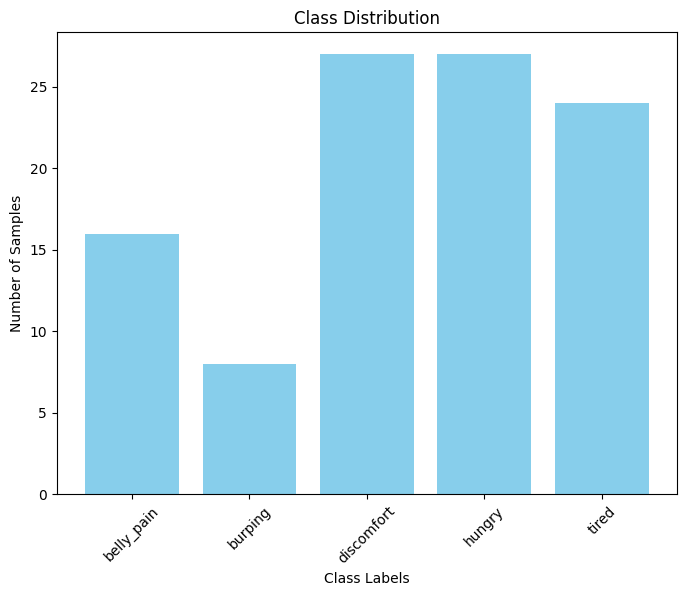

In [ ]:
# Print class distributions
print(f"Total samples: {len(downsampled_labels)}")
unique_labels, counts = np.unique(downsampled_labels, return_counts=True)
print(f"Number of classes: {len(unique_labels)}")
print("Class distribution:")
for label, count in zip(unique_labels, counts):
    print(f" - {label}: {count}")

plt.figure(figsize=(8, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.title("Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

# Apply the model

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


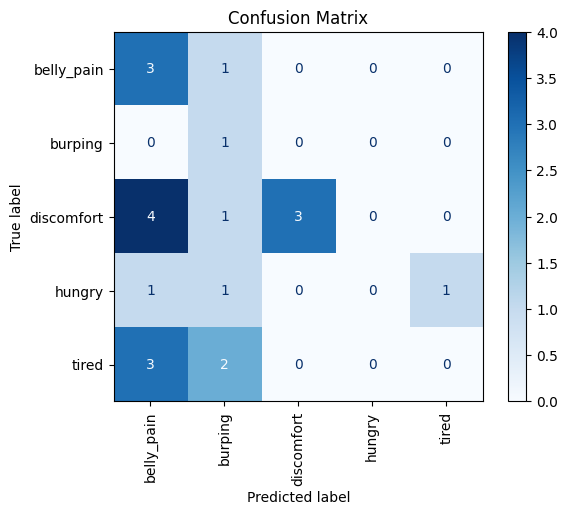

Accuracy: 0.33
Precision: 0.44
Recall: 0.33
F1-Score: 0.30


In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train_2d, y_train)
knn_metrics = evaluate_model(knn_model, X_test_2d, y_test, label_encoder.classes_)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


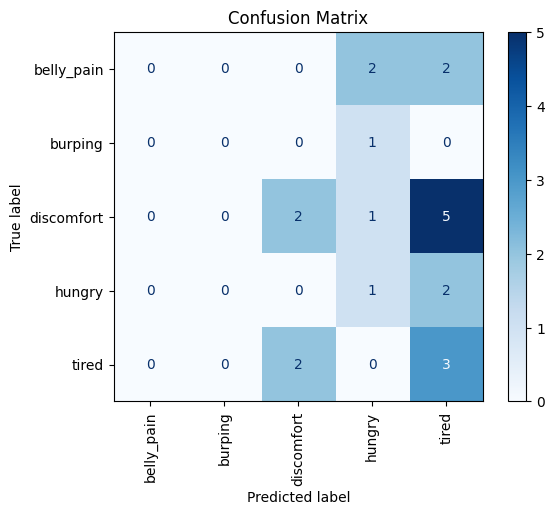

Accuracy: 0.29
Precision: 0.28
Recall: 0.29
F1-Score: 0.25


In [ ]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_2d, y_train)
nb_metrics = evaluate_model(nb_model, X_test_2d, y_test, label_encoder.classes_)

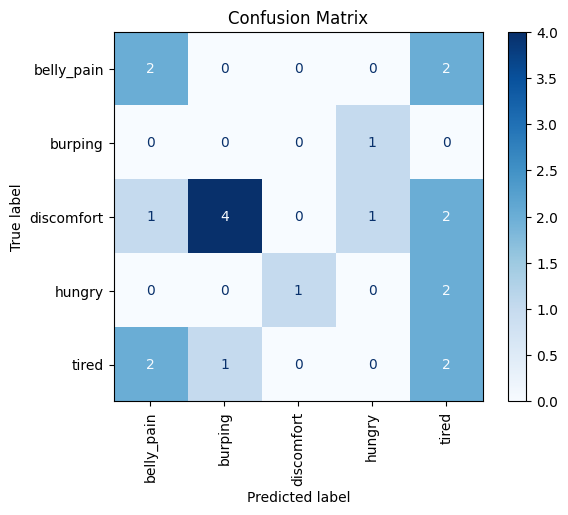

Accuracy: 0.19
Precision: 0.14
Recall: 0.19
F1-Score: 0.16


In [ ]:
# SVM
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train_2d, y_train)
svm_metrics = evaluate_model(svm_model, X_test_2d, y_test, label_encoder.classes_)

# Compare results

In [ ]:
results = {
    "KNN": knn_metrics["Accuracy"],
    "Naive Bayes": nb_metrics["Accuracy"],
    "SVM": svm_metrics["Accuracy"]
}

print("\nModel Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.2f}")


Model Comparison:
KNN: 0.33
Naive Bayes: 0.29
SVM: 0.19


In [ ]:
def predict_audio(model, file_path, label_encoder, fixed_length=100):
    # Ekstraksi fitur MFCC dari file audio
    mfcc_features = extract_mfcc(file_path, fixed_length=fixed_length)

    if mfcc_features is None:
        print(f"❌ Gagal membaca file: {file_path}")
        return

    # Ubah bentuk fitur agar sesuai dengan model (reshape menjadi 2D)
    mfcc_features = mfcc_features.reshape(1, -1)

    # Prediksi kelas
    predicted_label = model.predict(mfcc_features)[0]

    # Konversi dari angka ke nama label
    predicted_class = label_encoder.inverse_transform([predicted_label])[0]

    print(f"✅ File: {file_path}")
    print(f"🎯 Prediksi Kelas: {predicted_class}")

    return predicted_class


In [ ]:
import random

# Pilih suara acak dari dataset untuk diuji
random_folder = random.choice(os.listdir(base_dir))
random_folder_path = os.path.join(base_dir, random_folder)

# Ambil file wav acak dari folder
random_file = random.choice(os.listdir(random_folder_path))
random_file_path = os.path.join(random_folder_path, random_file)

print(f"🔍 File yang diuji: {random_file_path}")


🔍 File yang diuji: /content/drive/MyDrive/datasets/donateacry_corpus/hungry/a7b13b65-da2c-48ec-8aed-46adcaba705f-1430823489236-1.7-f-26-hu.wav


In [ ]:
print("\n🔹 Prediksi dengan KNN:")
predict_audio(knn_model, random_file_path, label_encoder)

print("\n🔹 Prediksi dengan Naive Bayes:")
predict_audio(nb_model, random_file_path, label_encoder)

print("\n🔹 Prediksi dengan SVM:")
predict_audio(svm_model, random_file_path, label_encoder)



🔹 Prediksi dengan KNN:
✅ File: /content/drive/MyDrive/datasets/donateacry_corpus/hungry/a7b13b65-da2c-48ec-8aed-46adcaba705f-1430823489236-1.7-f-26-hu.wav
🎯 Prediksi Kelas: hungry

🔹 Prediksi dengan Naive Bayes:
✅ File: /content/drive/MyDrive/datasets/donateacry_corpus/hungry/a7b13b65-da2c-48ec-8aed-46adcaba705f-1430823489236-1.7-f-26-hu.wav
🎯 Prediksi Kelas: hungry

🔹 Prediksi dengan SVM:
✅ File: /content/drive/MyDrive/datasets/donateacry_corpus/hungry/a7b13b65-da2c-48ec-8aed-46adcaba705f-1430823489236-1.7-f-26-hu.wav
🎯 Prediksi Kelas: hungry


'hungry'

Perbandingan Recall dan F1-Score untuk masing-masing model:
KNN => Recall: 0.33, F1-Score: 0.30
Naive Bayes => Recall: 0.29, F1-Score: 0.25
SVM => Recall: 0.19, F1-Score: 0.16


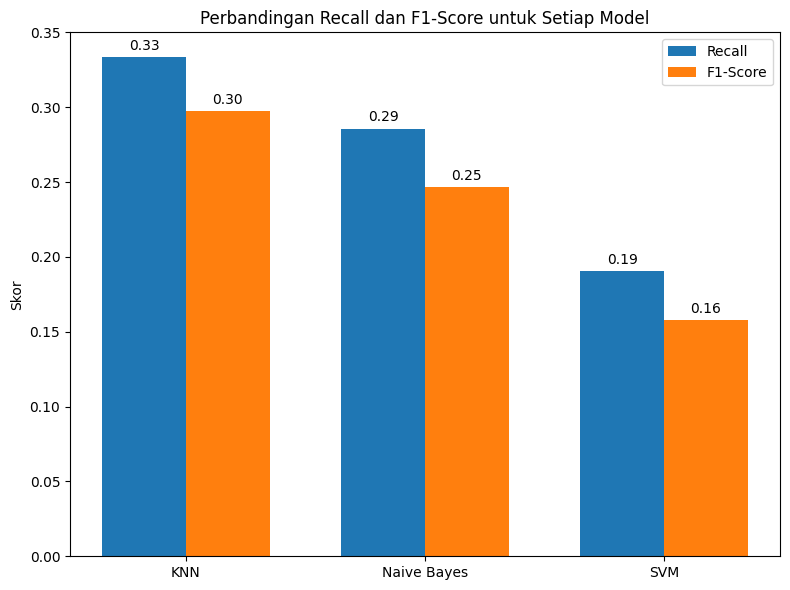

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Misal, knn_metrics, nb_metrics, dan svm_metrics sudah dihitung dengan fungsi evaluate_model sebelumnya

# Mengumpulkan metrik dari setiap model
models = ["KNN", "Naive Bayes", "SVM"]
recall_scores = [knn_metrics["Recall"], nb_metrics["Recall"], svm_metrics["Recall"]]
f1_scores = [knn_metrics["F1-Score"], nb_metrics["F1-Score"], svm_metrics["F1-Score"]]

# Menampilkan metrik di konsol
print("Perbandingan Recall dan F1-Score untuk masing-masing model:")
for model, rec, f1 in zip(models, recall_scores, f1_scores):
    print(f"{model} => Recall: {rec:.2f}, F1-Score: {f1:.2f}")

# Visualisasi dalam bentuk grafik batang
x = np.arange(len(models))  # label posisi untuk tiap model
width = 0.35  # lebar batang

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, recall_scores, width, label='Recall')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score')

# Tambahkan label, judul, dan keterangan sumbu
ax.set_ylabel('Skor')
ax.set_title('Perbandingan Recall dan F1-Score untuk Setiap Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Menambahkan nilai di atas tiap batang
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # jarak 3 titik ke atas
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

fig.tight_layout()
plt.show()


In [ ]:
def evaluate_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title("Confusion Matrix")
    plt.show()

    metrics = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Confusion Matrix": cm
    }

    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    return metrics


In [ ]:
import os

base_dir = "/content/drive/MyDrive/datasets/donateacry_corpus"
class_files = {}

# Mengiterasi semua file dalam base_dir
for subdir, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".wav"):
            class_name = os.path.basename(subdir)
            file_path = os.path.join(subdir, file)
            if class_name not in class_files:
                class_files[class_name] = []
            class_files[class_name].append(file_path)

# Menampilkan jumlah file dan daftar file per kelas
for class_name, files in class_files.items():
    print(f"Class: {class_name} - {len(files)} file(s)")
    for f in files:
        print("  ", f)
    print("\n")


Class: hungry - 382 file(s)
   /content/drive/MyDrive/datasets/donateacry_corpus/hungry/22b43570-d440-475b-b2f1-e528c81081f7-1430663490095-1.7-m-04-hu.wav
   /content/drive/MyDrive/datasets/donateacry_corpus/hungry/86c2b87a-ae7c-46a3-b6fb-7ebe748812cf-1430036593222-1.7-f-26-hu.wav
   /content/drive/MyDrive/datasets/donateacry_corpus/hungry/F3BAEDDA-CDC0-4A65-90EE-5C372CEE4F3B-1437012044-1.1-m-26-hu.wav
   /content/drive/MyDrive/datasets/donateacry_corpus/hungry/D1CB71F9-EF76-49B3-A703-41D557444D21-1436863366-1.1-m-04-hu.wav
   /content/drive/MyDrive/datasets/donateacry_corpus/hungry/9090c7a3-bebc-4485-aafc-64e4298da3ac-1430088396663-1.7-f-26-hu.wav
   /content/drive/MyDrive/datasets/donateacry_corpus/hungry/5C2F730C-9721-40B7-A2D8-C257DB518978-1429966336-1.0-m-04-hu.wav
   /content/drive/MyDrive/datasets/donateacry_corpus/hungry/dc5429de-26b4-48e2-bc47-bc607b9bba06-1430741828918-1.7-f-72-hu.wav
   /content/drive/MyDrive/datasets/donateacry_corpus/hungry/539FDD32-6326-422E-A707-FCF063D3